# TESTING DIFFERENT ML ALGORITHMS TO PREDICT MLB WINS IN A SEASON 

In [4]:
import pandas as pd
import os
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
from pprint import pprint

height has been deprecated.



In [5]:
teams_df = pd.read_csv('Teams.csv').reset_index()

##### DROP unecessary columns
> reason: do these columns really have an influence on number of wins? -- they'll add noise to the model

In [6]:
drop_cols = ['lgID','divID','Rank','Ghome',
             'L','DivWin','WCWin','LgWin','WSWin','SF',
             'name','park','attendance','BPF','PPF','teamIDBR',
             'teamIDlahman45','teamIDretro','franchID']

df = teams_df.drop(drop_cols, axis=1)

##### CHECK FOR NULL VALUES
> reason: have to find a balance between dropping null values for columns that you believe could have more of an impact on performance than ones that don't 

In [7]:
print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 120, 144, 859, 2325, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 317, 0]


##### Hit by Pitch probably doesn't influence wins much as much as SO/DP...

In [8]:
df = df.drop(['CS','HBP'], axis=1)

##### Fill all NaN values with median of that entire column
> all NaN values should now be the same number

In [9]:
df['SO'] = df['SO'].fillna(df['SO'].median())
df['DP'] = df['DP'].fillna(df['DP'].median())
df['SB'] = df['SB'].fillna(df['SB'].median())

###### check for NaN values again 

In [14]:
print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# VISUALIZE 

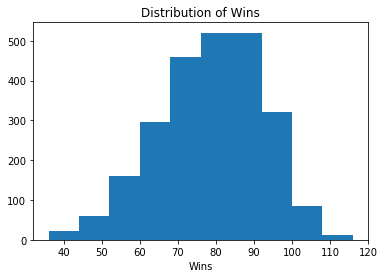

In [26]:
# matplotlib plots inline  
%matplotlib inline

# Plotting distribution of wins
plt.hist(df['W'])
plt.xlabel('Wins')
plt.title('Distribution of Wins')

plt.show()

In [27]:
df['W'].mean()

78.17088091353996

> "...It can be useful to create bins for your target column while exploring your data, but you need to make sure not to include any feature that you generate from your target column when you train the model. Including a column of labels generated from the target column in your training set would be like giving your model the answers to the test..."

In [28]:
# Creating bins for the win column
def assign_win_bins(W):
    if W < 50:
        return 1
    if W >= 50 and W <= 69:
        return 2
    if W >= 70 and W <= 89:
        return 3
    if W >= 90 and W <= 109:
        return 4
    if W >= 110:
        return 5

##### apply assign_win_bins() function to every value in 'W' column but enter output in 'win_bins' column

In [29]:
df['win_bins'] = df['W'].apply(assign_win_bins)

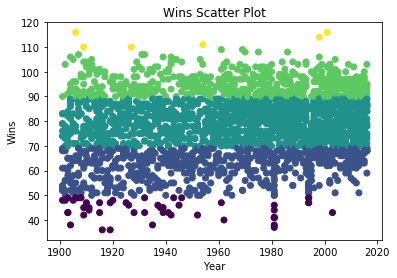

In [30]:
# Plotting scatter graph of Year vs. Wins
plt.scatter(df['yearID'], df['W'], c=df['win_bins'])
plt.title('Wins Scatter Plot')
plt.xlabel('Year')
plt.ylabel('Wins')

plt.show()

##### DROP  all years before 1900
    > logic: game was played different then, comparing scores to back then would be more difficuly

In [31]:
df = df[df['yearID'] > 1900]

> Since there were different numbers of games we need to get a ratio that doesnt bias the years where more games were played (i.e. more opportunities to win).  So we create a ratio of runs per game by getting runs/year & games/year separately...

In [32]:
runs_per_year = {}
games_per_year = {}

for i, row in df.iterrows():
    year = row['yearID']
    runs = row['R']
    games = row['G']
    if year in runs_per_year:
        runs_per_year[year] = runs_per_year[year] + runs
        games_per_year[year] = games_per_year[year] + games
    else:
        runs_per_year[year] = runs
        games_per_year[year] = games

In [33]:
# Create MLB runs per game (per year) dictionary
mlb_runs_per_game = {}
for k, v in games_per_year.items():
    year = k
    games = v
    runs = runs_per_year[year]    #runs dictionary short syntax
    mlb_runs_per_game[year] = runs / games

##### sort dictionary and unzip them into tuples to plot

In [34]:
# Create lists from mlb_runs_per_game dictionary
lists = sorted(mlb_runs_per_game.items())
x, y = zip(*lists)

##### Create line plot of Year vs. MLB runs per Game

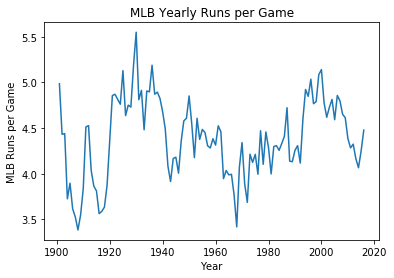

In [35]:
# Create line plot of Year vs. MLB runs per Game
plt.plot(x, y)
plt.title('MLB Yearly Runs per Game')
plt.xlabel('Year')
plt.ylabel('MLB Runs per Game')

plt.show()

# ADDING NEW FEATURES
> "When dealing with continuous data and creating linear models, integer values such as a year can cause issues. It is unlikely that the number 1950 will have the same relationship to the rest of the data that the model will infer" --- so we create dummy dfs to represent these columns in the ML algorithm.

In [36]:
def assign_label(year):
    if year < 1920:
        return 1
    elif year >= 1920 and year <= 1941:
        return 2
    elif year >= 1942 and year <= 1945:
        return 3
    elif year >= 1946 and year <= 1962:
        return 4
    elif year >= 1963 and year <= 1976:
        return 5
    elif year >= 1977 and year <= 1992:
        return 6
    elif year >= 1993 and year <= 2009:
        return 7
    elif year >= 2010:
        return 8

In [37]:
# Add `year_label` column to `df`    
df['year_label'] = df['yearID'].apply(assign_label)

> year_label corresponds to yearID column 

In [39]:
dummy_df = pd.get_dummies(df['year_label'], prefix='era')

In [40]:
# Concatenate `df` and `dummy_df`
df = pd.concat([df, dummy_df], axis=1)

In [41]:
# Create column for MLB runs per game from the mlb_runs_per_game dictionary
def assign_mlb_rpg(year):
    '''feed the df row in the yearid column (which is the year in dictionary)...
       and itll return that runs_per_game number generated from it'''
    return mlb_runs_per_game[year]

In [42]:
df['mlb_rpg'] = df['yearID'].apply(assign_mlb_rpg)

In [43]:
def assign_decade(year):
    if year < 1920:
        return 1910
    elif year >= 1920 and year <= 1929:
        return 1920
    elif year >= 1930 and year <= 1939:
        return 1930
    elif year >= 1940 and year <= 1949:
        return 1940
    elif year >= 1950 and year <= 1959:
        return 1950
    elif year >= 1960 and year <= 1969:
        return 1960
    elif year >= 1970 and year <= 1979:
        return 1970
    elif year >= 1980 and year <= 1989:
        return 1980
    elif year >= 1990 and year <= 1999:
        return 1990
    elif year >= 2000 and year <= 2009:
        return 2000
    elif year >= 2010:
        return 2010

In [44]:
df['decade_label'] = df['yearID'].apply(assign_decade)
decade_df = pd.get_dummies(df['decade_label'], prefix='decade')
df = pd.concat([df, decade_df], axis=1)

In [45]:
# Drop unnecessary columns
df = df.drop(['yearID','year_label','decade_label'], axis=1)

In [46]:
df['R_per_game'] = df['R'] / df['G']
df['RA_per_game'] = df['RA'] / df['G']

#### create scatter plots to see how well newly created variables correlate with target varaible 

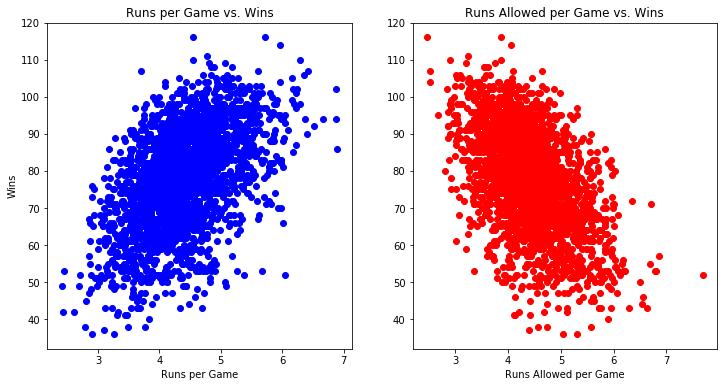

In [47]:
# Create scatter plots for runs per game vs. wins and runs allowed per game vs. wins
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(df['R_per_game'], df['W'], c='blue')
ax1.set_title('Runs per Game vs. Wins')
ax1.set_ylabel('Wins')
ax1.set_xlabel('Runs per Game')

ax2.scatter(df['RA_per_game'], df['W'], c='red')
ax2.set_title('Runs Allowed per Game vs. Wins')
ax2.set_xlabel('Runs Allowed per Game')

plt.show()

In [49]:
df.corr()['W']

index          0.141588
G              0.346700
W              1.000000
R              0.592417
AB             0.372550
H              0.470544
2B             0.325968
3B             0.038675
HR             0.336776
BB             0.407729
SO             0.136410
SB             0.117847
RA            -0.367107
ER            -0.237536
ERA           -0.383898
CG            -0.046849
SHO            0.446603
SV             0.387569
IPouts         0.412161
HA            -0.144305
HRA            0.067990
BBA           -0.141383
SOA            0.304865
E             -0.265708
DP             0.117998
FP             0.311010
win_bins       0.917519
era_1         -0.117870
era_2         -0.049904
era_3         -0.021139
era_4         -0.020561
era_5          0.068008
era_6          0.033125
era_7          0.035315
era_8          0.063495
mlb_rpg        0.007422
decade_1910   -0.117870
decade_1920   -0.030521
decade_1930   -0.035154
decade_1940   -0.028082
decade_1950   -0.023450
decade_1960    0

# MACHINE LEARNING

In [52]:
attributes = ['G','R','AB','H','2B','3B','HR','BB','SO','SB','RA','ER','ERA','CG',
            'SHO','SV','IPouts','HA','HRA','BBA','SOA','E','DP','FP','era_1','era_2','era_3',
              'era_4','era_5','era_6','era_7','era_8','decade_1910','decade_1920','decade_1930',
              'decade_1940','decade_1950','decade_1960','decade_1970','decade_1980','decade_1990','decade_2000',
              'decade_2010','R_per_game','RA_per_game','mlb_rpg']

data_attributes = df[attributes]

In [53]:
from sklearn.cluster import KMeans
from sklearn import metrics

# http://mnemstudio.org/clustering-k-means-example-1.htm

###### before creating the model you must determine the number of clusters you want
     > silhouette_score()--> you want a higher silhouette score, and the score decreases as more clusters are added
     > trade_off b/t score and # of clusters
     > determines what the silhouette_score() would be for 2 clusters, 3 clusters...10 clusters, 11 clusters

In [54]:
s_score_dict = {}
for i in range(2,11):
    km = KMeans(n_clusters=i, random_state=1)
    l = km.fit_predict(data_attributes)
    s_s = metrics.silhouette_score(data_attributes, l)
    s_score_dict[i] = [s_s]

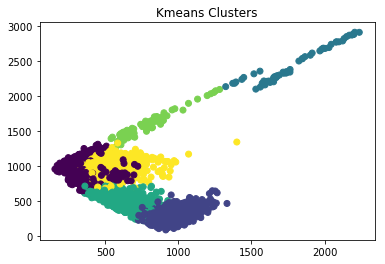

In [55]:
kmeans_model = KMeans(n_clusters=6, random_state=1)
distances = kmeans_model.fit_transform(data_attributes)

# Create scatter plot using labels from K-means model as color
labels = kmeans_model.labels_

plt.scatter(distances[:,0], distances[:,1], c=labels)
plt.title('Kmeans Clusters')

plt.show()

In [ ]:
df['labels'] = labels
attributes.append('labels')

##### SET UP FOR HOW YOU WANT THE MODEL TO BE TRAINED 
    > 0.75 of df = training data
    > 0.25 of df  = test data

    > add all relevant columns to train data (make sure target column isnt in there, in this case W) 

In [75]:
numeric_cols = ['G','R','AB','H','2B','3B','HR','BB','SO','SB','RA','ER','ERA','CG',
                'SHO','SV','IPouts','HA','HRA','BBA','SOA','E','DP','FP','era_1','era_2','era_3',
                'era_4','era_5','era_6','era_7','era_8','decade_1910','decade_1920','decade_1930',
                'decade_1940','decade_1950','decade_1960','decade_1970','decade_1980','decade_1990',
                'decade_2000','decade_2010','R_per_game','RA_per_game','mlb_rpg','labels','W']

data = df[numeric_cols]
# Split data DataFrame into train and test sets
train = data.sample(frac=0.75, random_state=1)
test = data.loc[~data.index.isin(train.index)]

x_train = train[attributes]  # attributes are defined under machine learning markdown cell
y_train = train['W']
x_test = test[attributes]
y_test = test['W']

# SELECTING ERROR METRIC AND MODEL


> "...Mean Absolute Error (MAE) is the metric you’ll use to determine how accurate your model is. It measures how close the predictions are to the eventual outcomes... This means that if, on average, your predictions miss the target amount by 5 wins, your error metric will be 5..."

In [76]:
from sklearn.linear_model import LinearRegression

# Import `mean_absolute_error` from `sklearn.metrics`
from sklearn.metrics import mean_absolute_error

##### train linear regression model

In [77]:
# Create Linear Regression model, fit model, and make predictions
lr = LinearRegression(normalize=True)
lr.fit(x_train, y_train)
predictions = lr.predict(x_test)

# Determine mean absolute error
mae = mean_absolute_error(y_test, predictions)

##### only off by on average, 2.9 games

In [78]:
print(mae)

2.93978455439


##### try 2nd ML algorithm, Ridge regression model

In [79]:
from sklearn.linear_model import RidgeCV

In [80]:
# Create Ridge Linear Regression model, fit model, and make predictions
rrm = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0), normalize=True)
rrm.fit(x_train, y_train)
predictions_rrm = rrm.predict(x_test)

##### only off by on average, 2.9 games

In [81]:
# Determine mean absolute error
mae_rrm = mean_absolute_error(y_test, predictions_rrm)
print(mae_rrm)

3.04297287597
